## Algoritmo de árbol de búsqueda cuántico
A continuación se presenta un ejemplo del algoritmo cuántico de arbol de búsqueda que resuelve el juego de 8-puzzle en python. Para ello nos basamos en el trabajo de Andreas Wichert en *Quantum Tree Search with Qiskit*

### Rompecabezas 3-puzzle
El rompecabezas de 3 se compone de tres fichas móviles numeradas en un marco de 2x2. Una celda del marco está vacía, y debido a esto los mosaicos se pueden mover para formar diferentes patrones. El objetivo es encontrar una serie de movimientos de fichas en el espacio en blanco que cambia el tablero de la configuración inicial a la configuración deseada. 
En el esquema de 2x2 hay 12 configuraciones posibles, para cualquier configuración solo hay dos movimientos posibles, en el sentido horario y antihorario.
La abstracción al modelo cuántico del puzzle consta de manejarlo como 4 objetos diferentes, tres celdas de número y una celda vacía. Cada objeto se codifica como dos qubits y una configuración de los cuatro objetos se puede representar como el registro de 8 qubits que llamaremos $\ket{x}$.

En esta representación:

 - Descriptores de posición son fijos
 - Descriptores de clase se mueven
 
 Se deben cumplir dos requisitos:
 
 - Para un tablero dado, la configuración y una regla de producción determinan la nueva configuración del tablero.
 - Determinar si la configuración es la configuración objetivo.
 
Existen cuatro posibles posiciones de la celda vacía. La función p (producciones) derermina la nueva configuración y la entrada de la función p consiste en la configuración actual y un bit m que indica la dirección del movimiento m=1 sentido horario y m=0 sentido antihorario.
Existen 8 posibles mapeos como salida de las producciones porque la celda vacía puede estar en 4 posiciones y puede cambiar a dos posibles movimientos por cada 4 posiciones. Esto se representa como una matriz $L$ que actúa sobre el ket m que representa la dirección y el ket x de 8 qubits que representa el estado de la tabla.
$L \ket{m}\ket{x} = \ket{m}\ket{\gamma}$

La función O definida como oráculo determina si la confuguración es nuestra configuración final deseada. Se define como un operador unitario $T$ que actúa también en la configuración de 8 + 1 qubits, esta vez el ket adicional c es un qubit auxiliar.


#### Definiciones
El objeto 1 está representado por 00, 2 está representado por 01, 3 está representado por 10 y el espacio vacío x está representado por 11. se tienen entonces 8 qubits, siguiendo el ejemplo del paper estos están representados como 10 11 00 01 para la configuración siguiente:

![alt](config2puzzle.png)

Comenzamos importando las bibliotecas necesarias e inicializando el modelo

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram # as plth, plot_state_city as psc
from qiskit.circuit.library import MCXGate
# from qiskit.quantum_info import Statevector as st
# from numpy import pi

# import numpy as np

In [2]:
# Se define un circuito cuántico con el nombre qc que usa 14 qubits y mide 8 qubits.
qc = QuantumCircuit(14,8)
#State Preparation 0-7
qc.x(2)
qc.x(3)
qc.x(4)
qc.x(7)
#Flag represented by qubit 8
#1St Trace (rastro) represented by qubits 9-12
#1St Path descriptor in superposition
qc.h(13)
qc.barrier()

def state_A():
    qc = QuantumCircuit(8)
    #State Preparation 0-7
    qc.x(2)
    qc.x(3)
    qc.x(4)
    qc.x(7)
    return qc

##### Reglas
En la tarea de 3 rompecabezas, tenemos cuatro **reglas** diferentes definidas por la posición del espacio vacío. Cada una de las reglas tiene dos instancias, ya sea moviendo el espacio vacío en el sentido de las agujas del reloj o en el sentido contrario a las agujas del reloj. Reconocemos las cuatro reglas e indicamos la presencia de una regla mediante un qubit. Usamos cuatro qubits que indican la presencia de las cuatro reglas y las llamamos el **rastro**. Necesitamos el **rastro** representado por los cuatro qubits, ya que no podemos eliminar la información y no podemos volver a calcular la salida. Descomputando, rehaceríamos las reglas. Adicionalmente, requerimos una **bandera** representada por un qubit que nos indique si la regla con la instanciación correspondiente se puede ejecutar o no. Finalmente, necesitamos un qubit que represente el **descriptor de ruta** que estará presente por superposición usando una puerta de Hadamard. 

En el primer ejemplo, la parte condicional de las reglas es implementada por la compuerta de Toffoli, llamada también ccx. Reconoce la posición del espacio vacío y lo indica configurando un qubit de los cuatro qubits 9 a 11 a uno.

In [3]:
# #If part of rules marked in trace
# qc.ccx(0,1,9)
# qc.ccx(2,3,10)
# qc.ccx(4,5,11)
# qc.ccx(6,7,12)

##### Ejecución de las Reglas
La ejecución de las reglas usa la puerta de Fredkin, también llamada puerta de intercambio controlado (CSWAP), utilizando la información de seguimiento y el descriptor de ruta configurando el qubit indicador (qubit 8) para indicar si la regla se va a ejecutar. El reinicio se realiza descomputando, repitiendo la operación para poner la bandera nuevamente en el estado cero. 

Cambiamos el descriptor de la ruta por la puerta NOT y ejecutamos la segunda instanciación de la regla dependiendo del valor de la traza; el ```qc.barrier()``` separará la representación en el circuito, dando como resultado el circuito cuántico indicado en la Figura.

In [4]:
def reglas(nombre:str,tamaño:int, bandera:int, rastro:tuple, descriptor:int) -> QuantumCircuit:
    """Reglas de movimiento para el 3-puzzle
    args
        nombre: Nombre de las reglas
        tamaño: El valor define el tamaño del circuito. 
        bandera: (Posición) Indica si la regla puede ejecutarse o no. El valor define la posición de la bandera.
        rastro: (Posiciones) Cuatro qubits indican la ubicación de la celda vacía. El valor define la posición del rastro.
        descriptor: (Posición) El descriptor de camino indica el movimiento a realizar. El valor define la posición del descriptor.
    """
    qc = QuantumCircuit(tamaño)

    #If part of rules marked in trace
    ##FIXME Esto va siempre??
    qc.ccx(0,1,rastro[0])
    qc.ccx(2,3,rastro[1])
    qc.ccx(4,5,rastro[2])
    qc.ccx(6,7,rastro[3])

    #Search empty state with the descriptor
    qc.ccx(rastro[0],descriptor,bandera)
    #Execute 1st then part by moving the empty space clockwise
    qc.cswap(bandera,0,4)
    qc.cswap(bandera,1,5)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[0],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[0],descriptor,bandera)
    #Execute 2th then part by moving the empty space anti-clockwise
    qc.cswap(bandera,0,2)
    qc.cswap(bandera,1,3)
    #Reset Flag
    qc.ccx(rastro[0],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    """The second rule is represented accordingly."""

    #If then rule (2) for empty at 2, 3 -> 6, 7 or 0, 1
    #Search empty state with the descriptor

    qc.ccx(rastro[1],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,0,2)
    qc.cswap(bandera,1,3)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[1],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[1],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,2,6)
    qc.cswap(bandera,3,7)
    #Reset Flag
    qc.ccx(rastro[1],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    """The third and the fourth rules are represented in the same way. """

    #If then rule (2) for empty at 2, 3 -> 6, 7 or 0, 1
    #Search empty state with the descriptor
    qc.ccx(rastro[2],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,4,6)
    qc.cswap(bandera,5,7)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[2],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[2],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,0,4)
    qc.cswap(bandera,1,5)
    #Reset Flag
    qc.ccx(rastro[2],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    #If then rule (2) for empty at 2, 3 -> 6, 7 or 0, 1
    #Search empty state with the descriptor
    qc.ccx(rastro[3],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,2,6)
    qc.cswap(bandera,3,7)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[3],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[3],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,4,6)
    qc.cswap(bandera,5,7)
    #Reset Flag
    qc.ccx(rastro[3],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()
    qc.name = nombre
    # display(
    #     qc.draw(output='mpl', fold=-1)
    # )
    return qc


In [5]:

"""Finally, we measure
the state represented by the 8 qubits."""
qc.append(reglas(nombre='reglas', tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))

qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.measure(3,3)
qc.measure(4,4)
qc.measure(5,5)
qc.measure(6,6)
qc.measure(7,7)


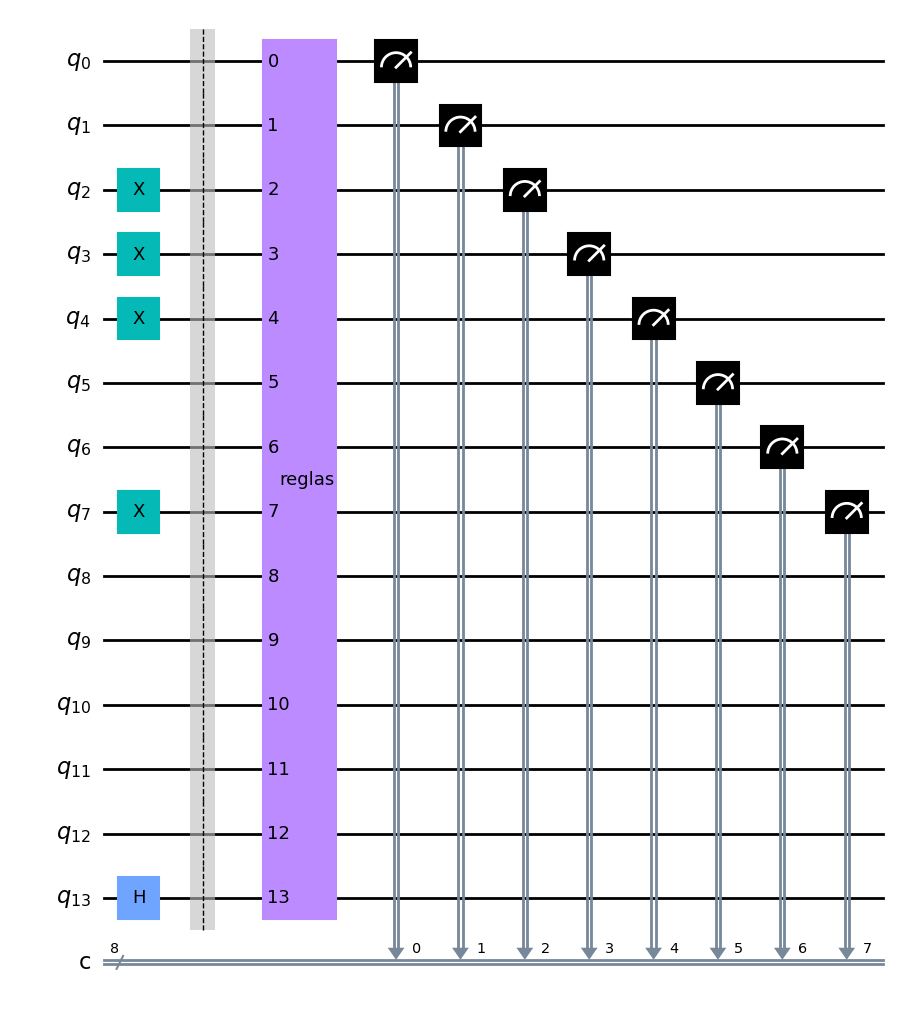

In [6]:
# Visualización del circuito
display(
    qc.draw(output='mpl')
)

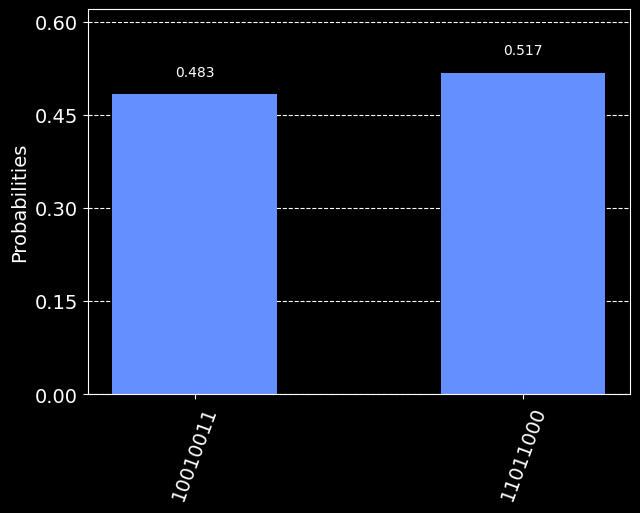

In [7]:
# Simulación
simulator = Aer.get_backend('qasm_simulator')
result=execute(qc,simulator).result()
counts = result.get_counts()
plot_histogram(counts)

#### Profundidad 2
La amplificación de Grover no se puede aplicar a menos de cuatro estados. Una búsqueda de profundidad uno para el rompecabezas de 3 parte los resultados en dos estados y una búsqueda de profundidad dos en cuatro estados. El operador L( 2 ) que describe la búsqueda de la profundidad dos se representa como

$L(2) \ket{m_2 , m_1}\ket{x} = \ket{m_2 , m_1}\ket{\gamma}$

con dos qubits representando el camino que tomará.

El operador T representa la función oráculo.

Con búsqueda en profundidad t = 2, se necesitan cuatro qubits adicionales para representar la nueva traza, un qubit adicional para el descriptor de ruta de la profundidad dos y un qubit auxiliar para la operación del oráculo. El circuito cuántico está representado por 20 qubits. Medimos el descriptor de ruta representado por dos qubits 13 y 18.

In [17]:


def oracle(size):
    qc = QuantumCircuit(size)
    gate = MCXGate(4)
    #Goal Configurations
    # qc.append(gate,[2, 3, 4, 7, size-1])
    #Alternative Goal Configurations
    # qc.append(gate,[0, 3, 6, 7, 19])
    # qc.append(gate,[0, 2, 3, 5, size-1])
    #Grover in depth two cannot resolve this since two solutions out of four are marked.
    # qc.append(gate,[0, 4, 5, 7, size-1])
    qc.append(gate,[0, 1, 4, 7, size-1])
    # qc.append(gate,[3, 4, 6, 7, size-1])
    # qc.append(gate,[3, 4, 5, 6, size-1])
    # qc.append(gate,[0, 1, 3, 6, size-1])
    qc.name="O"
    return qc
    
def reglas_inv(nombre:str, tamaño:int, bandera:int, rastro:tuple, descriptor:int) -> QuantumCircuit:
    qc = reglas(nombre, tamaño, bandera, rastro, descriptor)
    qc_inv = qc.inverse()
    qc_inv.name = nombre + "_inv"
    return qc_inv

def Grover():
    qc = QuantumCircuit(19)
    #Diffusor
    qc.h([13,18])
    qc.z([13,18])
    qc.cz(13,18)
    qc.h([13,18])
    qc.name="G"
    return qc
    
qc2 = QuantumCircuit(20,2)
#State Preparation 0-7
# Flag bit 8
#1St Trace 9-12
#1St Path Descriptor in superposition
qc2.h(13)
#1St Trace 14-17
#2th Path descriptor in superposition
qc2.h(18)
#Aux bit c indicating the solution is negated and
# put in superposition
qc2.x(19)
qc2.h(19)
qc2.barrier()
#Preperation of state
qc2.append(state_A(),range(8))
#Depth1
qc2.append(reglas(nombre="R1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
#Depth2 
qc2.append(reglas(nombre="R2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
#Oracle
qc2.append(oracle(20),range(20))
#Depth2 
qc2.append(reglas_inv(nombre="R2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
#Depth1
qc2.append(reglas_inv(nombre="R1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
#Redo Preperation
qc2.append(state_A(),range(8))
qc2.barrier()
#Redo Superposition of Aux Bit
qc2.h(19)
qc2.barrier()
qc2.append(Grover(),range(19))
qc2.measure(13,0)
qc2.measure(18,1)
# qc2.measure(19,2)
# qc2.measure(0,0)
# qc2.measure(1,1)
# qc2.measure(2,2)
# qc2.measure(3,3)
# qc2.measure(4,4)
# qc2.measure(5,5)
# qc2.measure(6,6)
# qc2.measure(7,7)

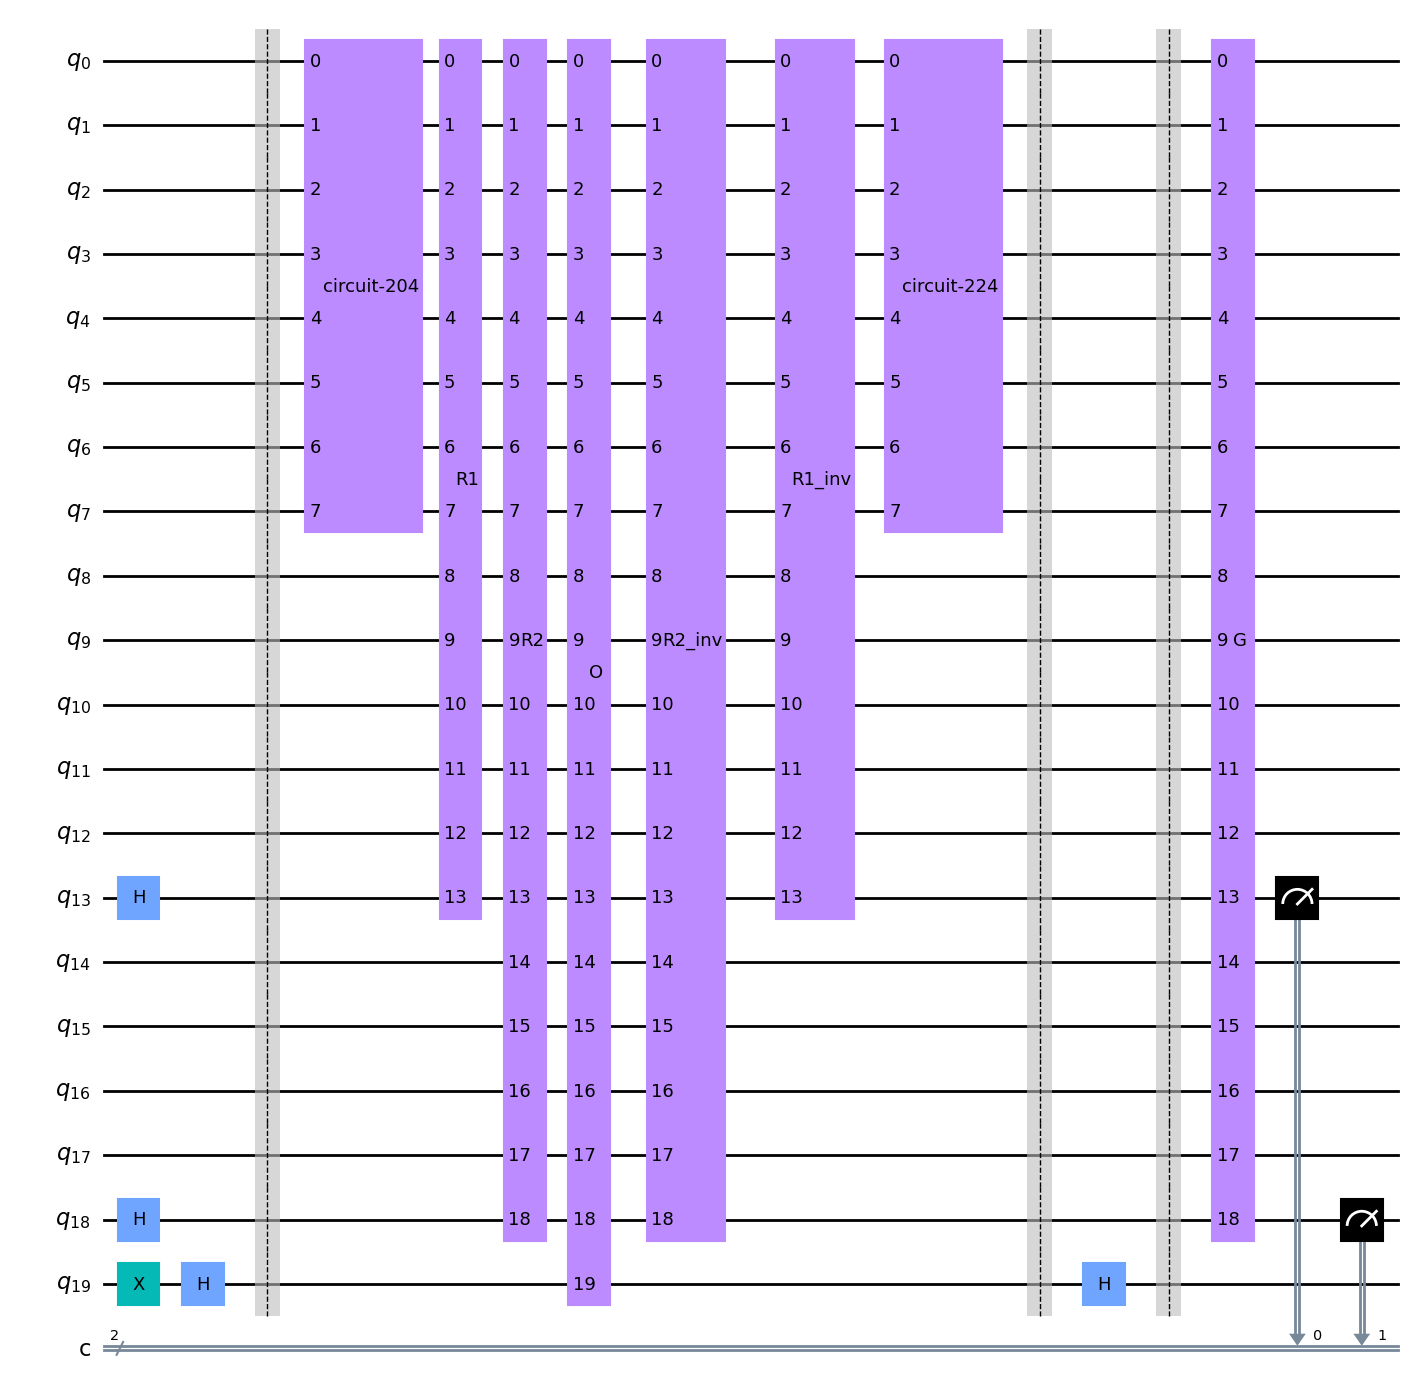

In [9]:
# # Visualización del circuito
display(
    qc2.draw(output='mpl')
)

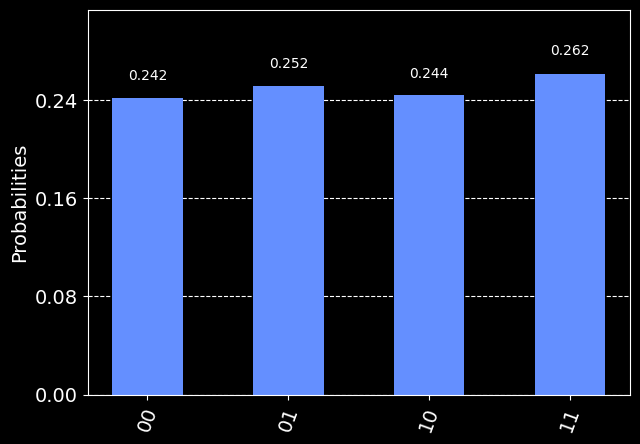

In [18]:
# Simulador 
simulator2 = Aer.get_backend('qasm_simulator')
result2=execute(qc2,simulator2, shots=512).result()
counts2 = result2.get_counts()
plot_histogram(counts2)

### Profundidad 3
Este caso es similar a los anteriores aunque el Grover es diferente.

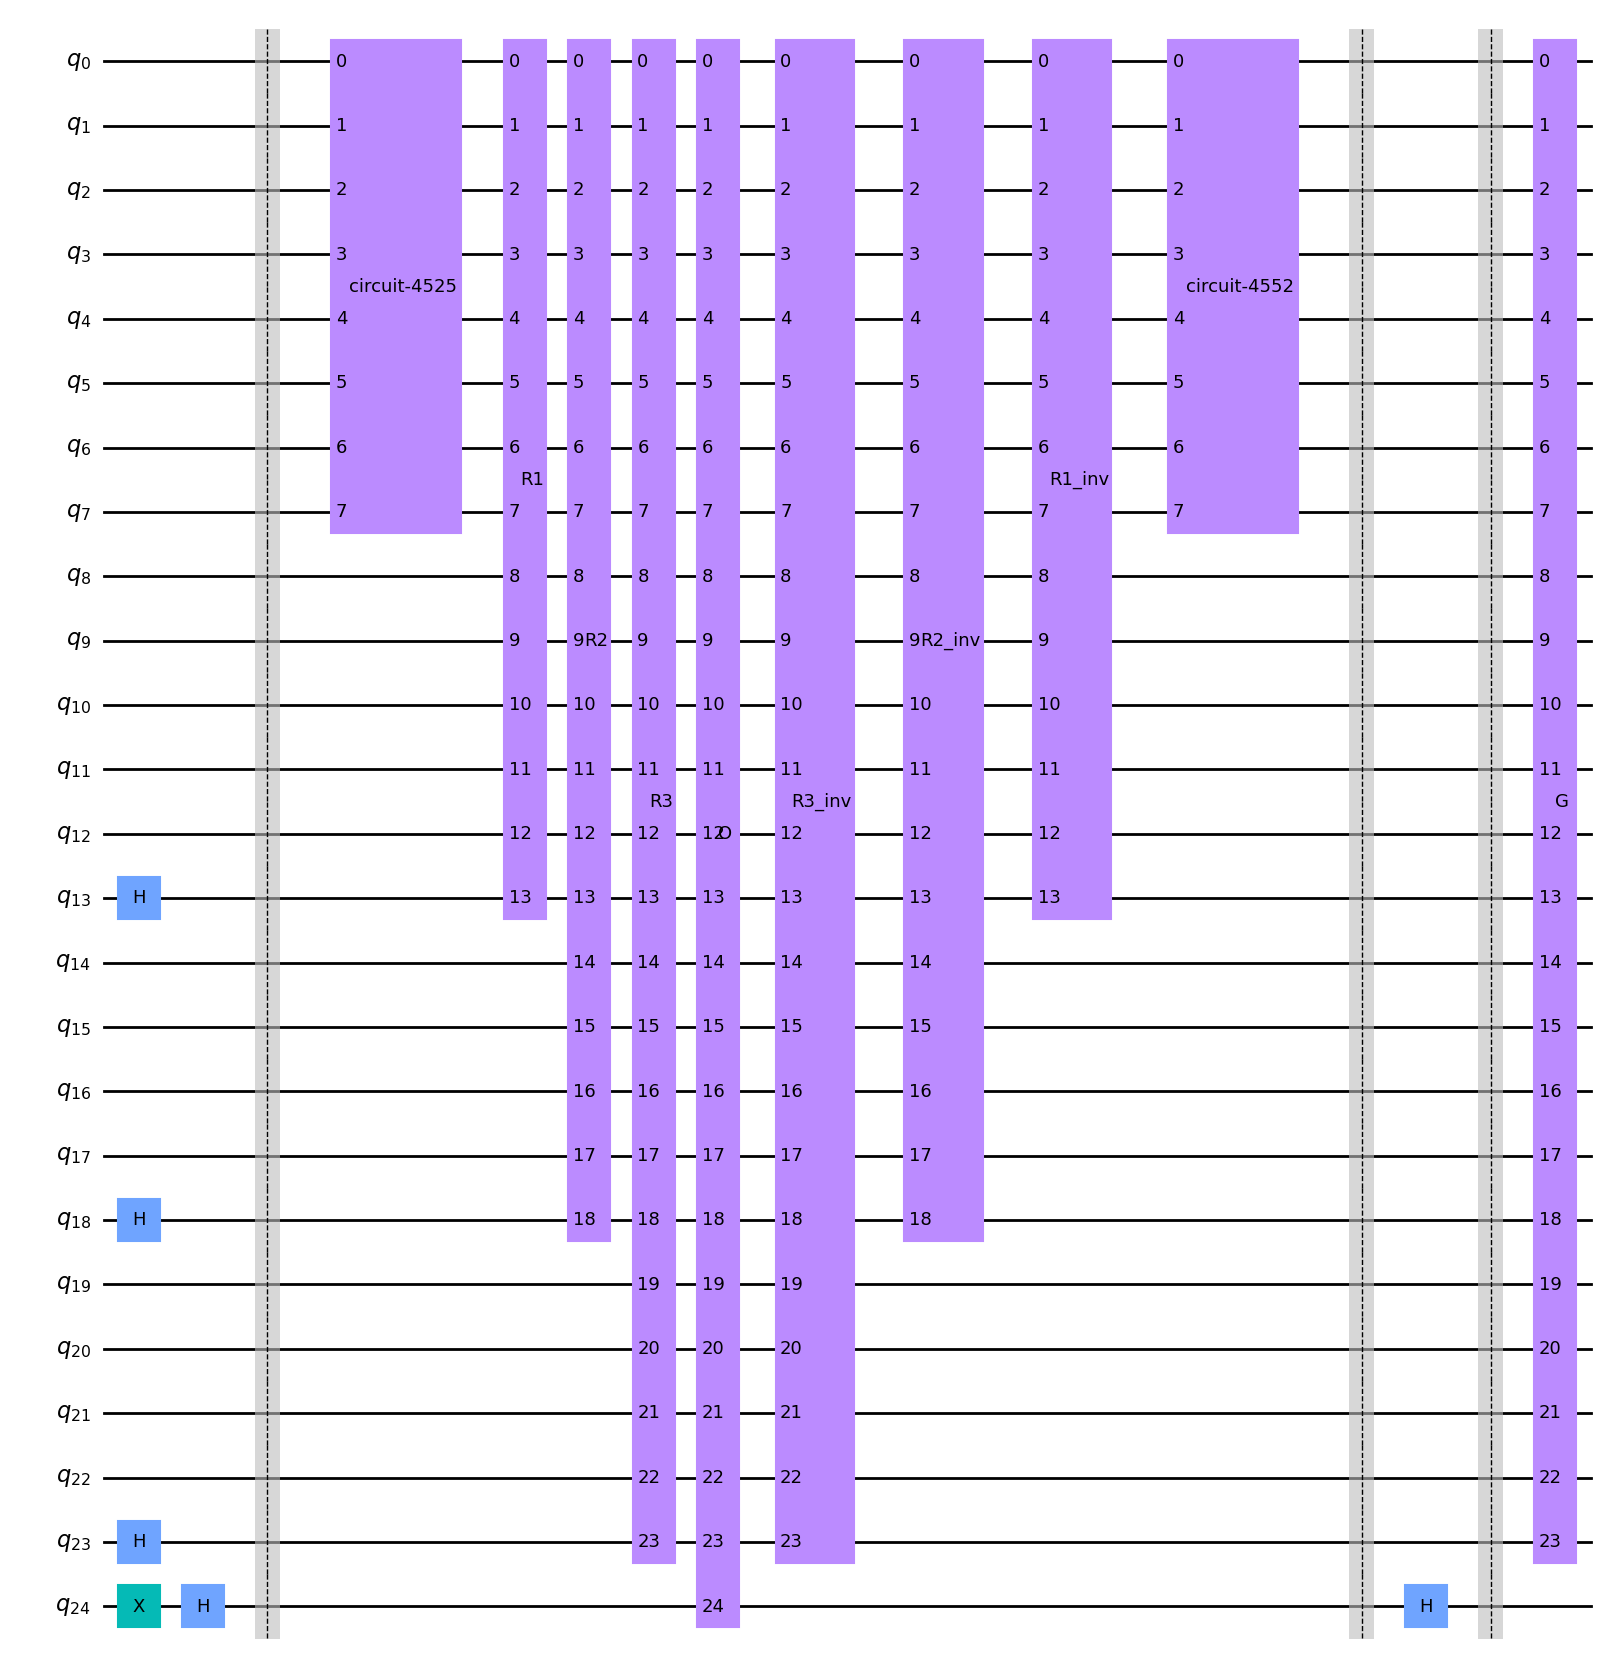

In [19]:
def Grover3():
    qc = QuantumCircuit(24)
    #Diffusor
    qc.h([13,18,23])
    qc.x([13,18,23])
    qc.h(13)
    qc.ccx(18,23,13)
    qc.h(13)
    qc.x([13,18,23])
    qc.h([13,18,23])
    qc.name="G"
    return qc
    
qc3 = QuantumCircuit(25)
qc3.h(13)
qc3.h(18)
qc3.h(23)
qc3.x(24)
qc3.h(24)
qc3.barrier()

qc3.append(state_A(),range(8))
#Depth1
qc3.append(reglas(nombre="R1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
#Depth2 
qc3.append(reglas(nombre="R2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
qc3.append(reglas(nombre="R3",tamaño=24,bandera=8,rastro=(19,20,21,22),descriptor=23),range(24))
#Oracle
qc3.append(oracle(25),range(25))
qc3.append(reglas_inv(nombre="R3",tamaño=24,bandera=8,rastro=(19,20,21,22),descriptor=23),range(24))
#Depth2 
qc3.append(reglas_inv(nombre="R2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
#Depth1
qc3.append(reglas_inv(nombre="R1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
#Redo Preperation
qc3.append(state_A(),range(8))
qc3.barrier()

qc3.h(24)
qc3.barrier()
qc3.append(Grover3(),range(24))

# Visualización del circuito
display(
    qc3.draw(output='mpl')
)


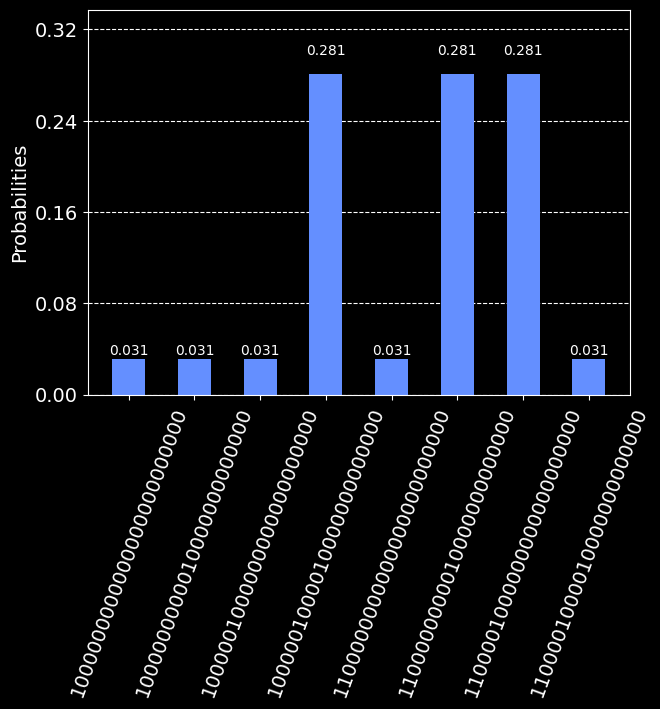

In [20]:
simulator3 = Aer.get_backend('statevector_simulator')
result3=execute(qc3,simulator3).result()
counts3 = result3.get_counts()
plot_histogram(counts3)